# Lab 4: Data Imputation using an Autoencoder

**Deadline**: Mon, March 01, 5:00pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Chris Lucasius <christopher.lucasius@mail.utoronto.ca>

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/17iJ46K1etzW6fqI-Ca2v4PznDJ1NSwtH?usp=sharing

In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [ ]:
import pandas as pd

## Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

In [ ]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

In [ ]:
sub_col = ["age", "yredu", "capgain", "caploss", "workhr"]

# for each column, report the minimum, maximum, and average value across the dataset
for i in sub_col:
    mini = np.min(df[i])
    maxi = np.max(df[i])
    avg = np.mean(df[i])

    print("For column " + i + ", minimum value = " + str(mini) + ", maximum value = " + str(maxi) + " and average value = " + str(avg) + ".")

# normalize the value to 0~1,
for i in sub_col:
    mini = np.min(df[i])
    maxi = np.max(df[i])
    df[i] = (df[i]-mini) / (maxi-mini) #(value-min) / (max-min)


For column age, minimum value = 17, maximum value = 90 and average value = 38.58164675532078.
For column yredu, minimum value = 1, maximum value = 16 and average value = 10.0806793403151.
For column capgain, minimum value = 0, maximum value = 99999 and average value = 1077.6488437087312.
For column caploss, minimum value = 0, maximum value = 4356 and average value = 87.303829734959.
For column workhr, minimum value = 1, maximum value = 99 and average value = 40.437455852092995.


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [ ]:
# hint: you can do something like this in pandas
percentage = sum(df["sex"] == " Male")/df.shape[0] * 100
print("Male percentage is " + str(percentage) + "%.")
print("Female percentage is " + str(100-percentage) + "%.")

Male percentage is 66.92054912318419%.
Female percentage is 33.07945087681581%.


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [ ]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [ ]:
print("Number of records for missing features is " + str(df_with_missing.shape[0]) + ".")

percentage = df_with_missing.shape[0] / df.shape[0] * 100
print("The percentage of records were removed is " + str(percentage) + "%.")

Number of records for missing features is 1843.
The percentage of records were removed is 5.660145572924664%.


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [ ]:
print(set(df_not_missing["work"])) # print unique possible values for feature "work" in df_not_missing

{' Self-emp-not-inc', ' State-gov', ' Local-gov', ' Federal-gov', ' Private', ' Without-pay', ' Self-emp-inc'}


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [ ]:
data = pd.get_dummies(df_not_missing)

In [ ]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [ ]:
print("Number of columns(features) in the dataframe is " + str(data.shape[1]) + ".")

Number of columns(features) in the dataframe is 57.


Answer:

According to the previous output:

    1 column for age
    1 column for yredu
    1 column for capgain
    1 column for caploss
    1 column for workhr
    7 columns for work
    7 columns for marriage
    14 columns for occupation
    16 columns for edu
    6 columns for relationship
    2 for sex

57 columns in total.

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [ ]:
datanp = data.values.astype(np.float32)

In [ ]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values` 
    # (created above) useful.
    idx = np.argmax(onehot) # Returns the indices of the maximum values along an axis.
    return cat_values[feature][idx]


In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
num_train = int(0.7 * len(datanp))
num_val = int((len(datanp) - num_train) / 2)

np.random.shuffle(datanp)
trainData = datanp[:num_train, :]
valData = datanp[num_train:num_train+num_val, :]
testData = datanp[num_train+num_val:, :]

print("Number of items in training set is " + str(len(trainData)) + ".")
print("Number of items in validation set is " + str(len(valData)) + ".")
print("Number of items in testing set is " + str(len(testData)) + ".")

Number of items in training set is 21502.
Number of items in validation set is 4608.
Number of items in testing set is 4608.


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.name = "auto_encoder"
        self.encoder = nn.Sequential(
            nn.Linear(57, 32), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(32, 11)
        )
        self.decoder = nn.Sequential(
            nn.Linear(11, 32), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(32, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

Answer: 

By using the sigmoid activation function in the decoder, we can make sure the output from the decoder is mapped between 0 to 1, since it matched with the normalized input which are also mapped between 0 to 1.



## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Copied from lab 2, to obtained the file for each hyperparameters tunning results
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, batch_size, num_epochs=5, learning_rate=1e-4, graph=True):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loss, train_acc, val_loss, val_acc = [], [], [], []

    # training
    for epoch in range(num_epochs):

        # training datas
        loss_train = 0
        for data in train_loader:

            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward() # with gradient calculates and weights/model update
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()
                  
        train_loss.append(loss_train/len(train_loader))
        train_acc.append(get_accuracy(model, train_loader))

        # validation datas
        loss_val = 0
        for data in valid_loader:
            
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)

            loss_val += loss.item()

        val_loss.append(loss_val/len(valid_loader))
        val_acc.append(get_accuracy(model, valid_loader))

        # check model from point to point
        if graph:
            print ("Epoch " + str(epoch) + " finished, with Training Accuracy: " + str(train_acc[-1]) + " and Validation Accuracy: " + str(val_acc[-1]))

        # save the model
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path) 

    # output loss/accuracy
    print("Final training loss = " + str(train_loss[-1]))
    print("Final validation loss = " + str(val_loss[-1]))
    print("Final training accuracy = " + str(train_acc[-1]))
    print("Final validation accuracy = " + str(val_acc[-1]))

    # plotting
    if graph:
        plt.plot(range(num_epochs), train_loss, label='Training')
        plt.plot(range(num_epochs), val_loss, label='Validation')
        plt.xlabel("Number of Epoch Iterations")
        plt.ylabel("Loss")
        plt.legend(loc = 'best')
        plt.title("Training/Validation Loss")
        plt.show()

        plt.plot(range(num_epochs), train_acc, label = 'Training')
        plt.plot(range(num_epochs), val_acc, label = 'Validation')
        plt.xlabel("Number of Epoch Iterations")
        plt.ylabel("Accuarcy")
        plt.legend(loc = 'best')
        plt.title("Training/Validation Accuracy")
        plt.show()


     

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Epoch 0 finished, with Training Accuracy: 0.10671875484451059 and Validation Accuracy: 0.10767505787037036
Epoch 1 finished, with Training Accuracy: 0.1143614547483955 and Validation Accuracy: 0.11534288194444445
Epoch 2 finished, with Training Accuracy: 0.20893405264626547 and Validation Accuracy: 0.20988859953703703
Epoch 3 finished, with Training Accuracy: 0.3478746163147614 and Validation Accuracy: 0.34762008101851855
Epoch 4 finished, with Training Accuracy: 0.3997380088673922 and Validation Accuracy: 0.39890769675925924
Epoch 5 finished, with Training Accuracy: 0.44817536353207454 and Validation Accuracy: 0.4466869212962963
Epoch 6 finished, with Training Accuracy: 0.4482606269184262 and Validation Accuracy: 0.44675925925925924
Epoch 7 finished, with Training Accuracy: 0.4480590952779586 and Validation Accuracy: 0.4466145833333333
Epoch 8 finished, with Training Accuracy: 0.45635289740489254 and Validation Accuracy: 0.45500578703703703
Epoch 9 finished, with Training Accuracy: 0.

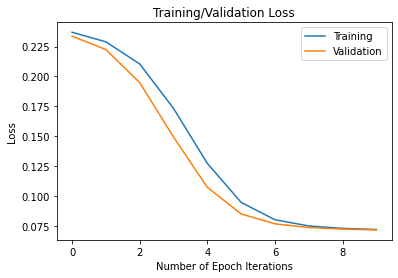

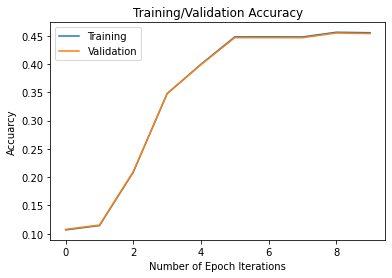

In [ ]:
model = AutoEncoder()
train_loader = torch.utils.data.DataLoader(trainData, batch_size=256, shuffle=True)
val_loader = torch.utils.data.DataLoader(valData, batch_size=256, shuffle=True)
train(model, train_loader, val_loader, batch_size=256, num_epochs=10, learning_rate=1e-4, graph=True)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

In [ ]:
# The initial parameters used in part c are batch_siz e= 256, num_epochs=10, learning_rate=1e-4.
# The final accuracies values are not that high is may be because we end the traning process too early, 
# so that it have not reach the better model/point for a better accuracy.
# To consider this circumstances, we try to use a larger num_epochs number as 50, with other hyperparameters unchanged.

model = AutoEncoder()
train_loader = torch.utils.data.DataLoader(trainData, batch_size=256, shuffle=True)
val_loader = torch.utils.data.DataLoader(valData, batch_size=256, shuffle=True)
train(model, train_loader, val_loader, batch_size=256, num_epochs=50, learning_rate=1e-4, graph=False)

Final training loss = 0.050068638376182036
Final validation loss = 0.05012087379064825
Final training accuracy = 0.5775431742783617
Final validation accuracy = 0.5777271412037037


In [ ]:
# By increasing the num_epochs number from 10 to 50, we observed that the validation accuracy improved from ~0.45 to ~0.58.
# As we already increases the num_epochs iterations, the accuracy is only ~0.58. 
# So, we may predict that within the sufficient number of epoches iterations, the learning_rate is too small,
# which reflects the step size that each updates are small, so it takes time to reach the minimum desired point.
# To consider this circumstances, we try to use a larger learning_rate number as 1e-3, with other hyperparamters unchanged.

model = AutoEncoder()
train_loader = torch.utils.data.DataLoader(trainData, batch_size=256, shuffle=True)
val_loader = torch.utils.data.DataLoader(valData, batch_size=256, shuffle=True)
train(model, train_loader, val_loader, batch_size=256, num_epochs=50, learning_rate=1e-3, graph=False)

Final training loss = 0.015828694438650495
Final validation loss = 0.017111554224458005
Final training accuracy = 0.6108656559079776
Final validation accuracy = 0.6083984375


In [ ]:
# By increasing the learning rate from 1e-4 to 1e-3, we observed that the validation accuracy improved from ~0.58 to ~0.61.
# So, we approved that by increasing the learning rate and num epochs, it improved the validation accuracy.
# Then, we are going to adjust the batch size number from 256 to a smaller number.
# Since, usually the batch size number is from 32 to 512, and 256 is already consider to be large batch size.
# To consider this circumstances, we try to use the batch_size as 64, with other hyperparamters unchanged.

model = AutoEncoder()
train_loader = torch.utils.data.DataLoader(trainData, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(valData, batch_size=64, shuffle=True)
train(model, train_loader, val_loader, batch_size=64, num_epochs=50, learning_rate=1e-4, graph=False)

Final training loss = 0.024338320163743838
Final validation loss = 0.02414250474733611
Final training accuracy = 0.6060599014045205
Final validation accuracy = 0.6048177083333334


In [ ]:
# By decreasing the batch size from 256 to 64, we observed that the validation accuracy imporved rom ~0.58 to ~0.60.
# So, we approved that by increasing the learning rate and num epochs, decreasing the batch size, it improved the validation accuracy.
# So, for the last trail, we take all imporved parameters into one trail to see the overall improvment of the model on accuracy.
# We choose batch_size = 64, num_epochs=50, learning_rate=1e-3, which are the good trails in the previous adjustments.

model = AutoEncoder()
train_loader = torch.utils.data.DataLoader(trainData, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(valData, batch_size=64, shuffle=True)
train(model, train_loader, val_loader, batch_size=64, num_epochs=50, learning_rate=1e-3, graph=False)

Final training loss = 0.012989027393771158
Final validation loss = 0.012087161406978138
Final training accuracy = 0.6523191641087651
Final validation accuracy = 0.6473162615740741


The final model with hyperparemeter selected is batch_size=64, num_epochs=50, learning_rate=1e-3, with traning accuracy = 0.65232 and validation accuracy = 0.64732.


## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [ ]:
model = AutoEncoder()
path = get_model_name("auto_encoder", batch_size = 64, learning_rate = 0.001, epoch=49)
state = torch.load(path)
model.load_state_dict(state)

test_loader = torch.utils.data.DataLoader(testData, batch_size=64, shuffle=True)
test_acc = get_accuracy(model, test_loader)

print("The test accuracy is " + str(test_acc) + ".")

The test accuracy is 0.6459418402777778.


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [ ]:
most_common_dic = {} # create a dictionary for finding the most common value in training sets for each category

# obtained the summation of values for each individual item within the each large category 
for col in catcols:
    sumation = np.sum(trainData[:, cat_index[col]:cat_index[col] + len(cat_values[col])], axis = 0)
    most_common_dic[col] = np.argmax(sumation)

# the most common item within each category is saved as index in the training set
print(most_common_dic)

{'work': 2, 'marriage': 2, 'occupation': 9, 'edu': 11, 'relationship': 0, 'sex': 1}


In [ ]:
total = 0
acc = 0
for col in catcols:
    most_common_type = most_common_dic[col]
    sumation = np.sum(testData[:, cat_index[col]:cat_index[col] + len(cat_values[col])], axis = 0) 

    # the baseline model will look at the most common value in the traning set as the prediction for the result to calculate accuracy
    acc += sumation[most_common_type]
    total += len(testData)

print("The test accuracy of the baseline model is " + str(acc / total) + ".")

The test accuracy of the baseline model is 0.4568504050925926.


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

Answer:

The test accuracy from part a for the best model is ~0.65 and the test accuracy from part b for baseline model is ~0.46. The model's accuracy is much better than the baseline model.


### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [ ]:
# I think it is reasonable for a human to able to guess this person's education level based on their other features to some extent.
# Since based on the occupation and work information, which are somehow related to the person's educational background, 
# can be used to predict for the educational level.
# But however, in this testing data, this person's occupation is prof-specialty, but his educational level is bachelars.
# It is reasonable in some extent, since we can identify several answers that are not that possible, for example, pre-school or high-shcool graduates.
# We might consider he possibly received college/university education. 
# However, to what extent he is educated to get the prof-specialty in detail, we might not know.
# So, it is reasonable to some extent.

get_features(testData[0])

{'edu': 'Bachelors',
 'marriage': 'Divorced',
 'occupation': 'Prof-specialty',
 'relationship': 'Not-in-family',
 'sex': 'Male',
 'work': 'Private'}

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [ ]:
col = 'edu'
subtestData = testData[0]
subtestData[cat_index[col]:cat_index[col]+len(cat_values[col])] = 0
subtestData = torch.from_numpy(subtestData)

model = AutoEncoder()
path = get_model_name("auto_encoder", batch_size = 64, learning_rate = 0.001, epoch=49)
state = torch.load(path)
model.load_state_dict(state)

out = model(subtestData).detach().cpu().numpy()
out_edu = get_feature(out, col)
print("The predicted education level provided by my model is " + out_edu + ".")


The predicted education level provided by my model is Bachelors.


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [ ]:
col = 'edu'
most_common_type = most_common_dic[col]
print("The predicted education level provided by the baseline model is " + cat_values[col][most_common_type] + ".")

The predicted education level provided by the baseline model is HS-grad.
